# Lab 6: Transformer Testing and Ringing Analysis

#### Andrew Phillips

## Prelab: Design and Manufacture Transformer

In this prelab, Suki and I designed a transformer to meet the specified requirements below:

- Input Voltage: 18V
- Output Voltage: 10V
- Output Power: 20W
- Switching Frequency: 50kHz
- Duty cycle: 35%
- Alpha: 80%
- Max peak flux density in ferrite core: 300mT
- Max RMS current density in copper wire: 10 Arms/mm^2

The calculations to find the required primary # of turns, secondary # of turns, air gap, and a value are performed in the code block below. As determined from the previous lab, the transformer will be running in DCM, so we used the equations derived in class for DCM mode. Using these equations, we calculated an a value of 0.864, a peak current of 8.50A, and a minimum number of turns of 8.63. Using these parameters, we decided on using 9 turns for the primary winding and 8 turns in the secondary winding, giving us an actual a value of 0.889, which we decided was close enough to our calculated a value. To determine the air gap, we used the geometric equations from Lesson 6 to account for flux fringing across the cross sectional area of our ferrite core. From this calculation we determined that an air gap of 18 thou was appropriate, so we shimmed our core by 9 thou (as the magnetic loop passes through the shimmed area twice). These parameters gave us a calculated inductance value of 19.51uH for the transformer, and remained within our calculated reluctance limits. To satisfy the max current density requirement, we decided to use 18AWG wire for our windings.

In [2]:
from math import sqrt, pi, asin, log

# prelab calcs
Vg = 18
Vo = 10
Pout = 20
fs = 50e3
Ts = 1/fs
D = 0.35
alpha = 0.8
Bmax = 0.3
a = Vo/Vg*(sqrt(alpha)-D)/D
L = 18e-6
Ro = 5
Acmin = 5.91e-5

# core dimensions, in mm
d = 7.9
r = d/2
lg = 0.4572 # guessing an air gap in mm, this is double what will be shimmed

print("a:", a)

# calculate peak current 
ipk = 2/sqrt(alpha)*(Vo/(a*Vg)+1)*Vo/(Ro*a)
print("ipk:", ipk)

# minimum # of turns required
Nmin = (L*ipk)/(Acmin*Bmax)
print("Nmin:", Nmin)
Np = 9
Ns = 8

# determine air gap
uo = pi*4e-7 # free air permeability
le_side = 2*(7+lg)*(10.65+lg) - (7+lg)*sqrt((9-lg)**2 - (7+lg)**2) - (9-lg)**2 * asin((7+lg)/(9-lg))
le_circle = pi*(r+lg)**2
le = 2*le_side + le_circle
le = le/2
print("le in mm^2:", le) # effective cross-sectional area in mm^2

le_m = le/1000**2
lg_m = lg/1000

# inductance calculations
L_calc = (le_m*uo*Np**2)/lg_m
print("calculated inductance value:",L_calc)

# check reluctance boundaries
J = 10
kf = 0.8 # fill factor
Aw = 65.78/1000**2 # winding area

W = 0.5*L*ipk**2
ll = 2*W/(Acmin*Bmax)
ul = (J*Aw*kf)**2/(2*W)
print("upper reluctance limit:",ll)
print("lower reluctance limit:",ul)

print(9*a)

a: 0.864170144444311
ipk: 8.501996573954825
Nmin: 8.631468602999824
le in mm^2: 87.64529572066044
calculated inductance value: 1.951269570409123e-05
upper reluctance limit: 73.38471649090314
lower reluctance limit: 0.00021284005178882461
7.777531299998799


After calculating the necessary parameters, we spun our transformer in lab. Because we spun our transformer before the transformer windings lecture, we wound our transformer in 2 layers, one for the primary and one for the secondary. Oblivious to this blunder, we rejoiced when we found that that our transformer measured in spec on the LCR meter, at 16.87uH!

![old_transformer](images/old_transformer.jpg)

![old_tranformer_test](images/old_transformer_test.jpg)

We calculated the energy stored in the air gap of our core in the code block below, using the equation E=Ts*V^2/R (for DCM operation). Compared to the energy stored in the air gap, the energy stored in the core itself is negligible. We calculated the energy stored in the air gap to be 0.4mJ.


In [3]:
# Energy calculation
E = 1/fs*Vo**2/Ro
print("Energy stored in air gap:", E)

Energy stored in air gap: 0.0004


## Data Collection

Lab questions 7 & 8: During the lab, we set up our lab hardware for flyback operation, inserting our custom transformer to replace the test transformer given to us last lab. Unfortunately, during testing, we realized that our transformer was unable to output any voltage above 4V even with our pot adjusted all the way counter clockwise. We hypothesized this was due to our layered winding strategy creating large leakage inductances, creating losses that prevent our output voltage from reaching the desired value. With this in mind, we decided to rewind our transformer, using 22AWG gauge wire to pursue a bifilar winding between the primary and secondary. When retesting with this new transformer, we captured waveforms with the behavior we expected, confirming our hypothesis. 

Bifilar winding transformer on the LCR meter:

![new_transformer_test](images/new_transformer_test.jpg)

We were then able to capture shunt and drain voltages at 4V, 7V, and 9V output (note: we accidently captured waveforms at 9V instead of 10V. This was our mistake and we will pay closer attention to the worksheet in the future!). We then adjusted the scope settings to capture the high frequency oscillations occuring at the FET turn-off and the lower frequency oscillations occuring at the diode turn-off.

## Data Plotting: Lab Questions 1-8

We captured waveforms at the following output voltages and input currents:

- 4.02V, 0.28A
- 7.02V, 0.71A
- 9.04V, 1.14A

Note: Our 4V drain voltage data was recorded with a 17V offset in the scope, so this offset has been removed in the code block below. The data is plotted and the inductance of our transformer are calculated in the code blocks below:

In [4]:
# import necessary python libraries
import pandas as pd
import matplotlib.pyplot as plt
import csv

# read funky Rigol CSV format
def read_rigol_csv(csv_file_name):
    with open(csv_file_name) as f:
        rows = list(csv.reader(f))
        i = 0
        while rows[0][i] != "":
            i = i+1
        numcols = i-2
        t0 = float(rows[1][numcols])
        dT = float(rows[1][numcols+1])
    data = pd.read_csv(csv_file_name, usecols=range(0,numcols), skiprows=[1])
    data['X'] = t0+data['X']*dT
    return data, t0, dT

Calculated turns ratio for 4.02V output: 0.7790697674418599
Calculated inductance for 4.02V output: 1.799999999999998e-05
Calculated turns ratio for 7.02V output: 0.836904761904762
Calculated inductance for 7.03V output: 1.844262295081968e-05
Calculated turns ratio for 9.04V output: 0.8333333333333333
Peak shunt voltage at 9.04V output: 0.3264
Calculated inductance for 9.04V output: 1.757812500000004e-05
Averaged calculated inductance: 1.8006915983606567e-05
Averaged turns ratio: 0.8164359542266517


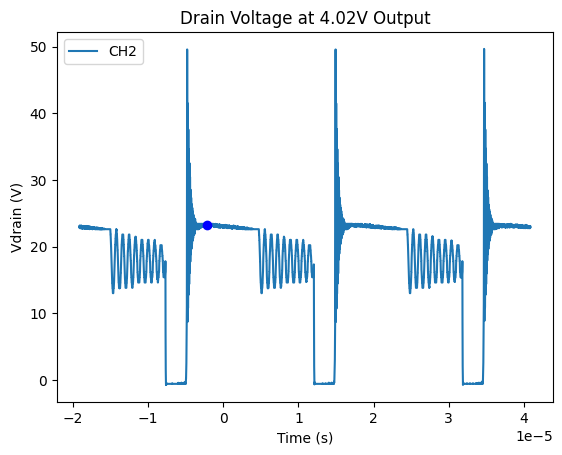

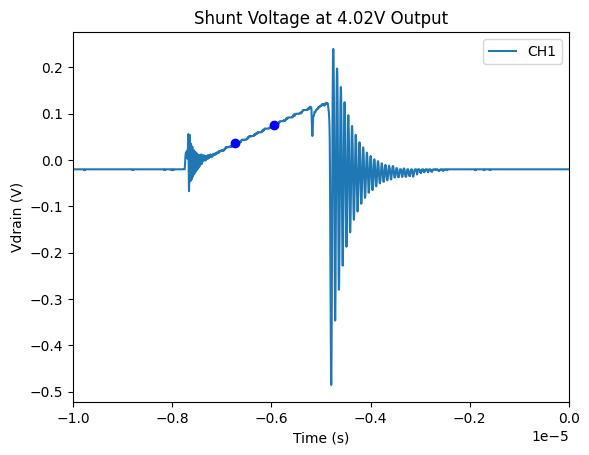

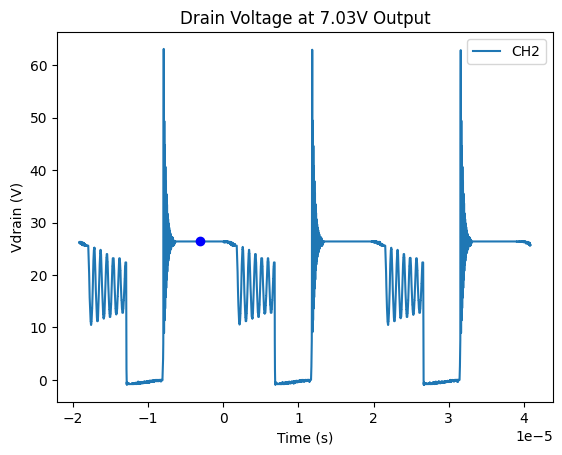

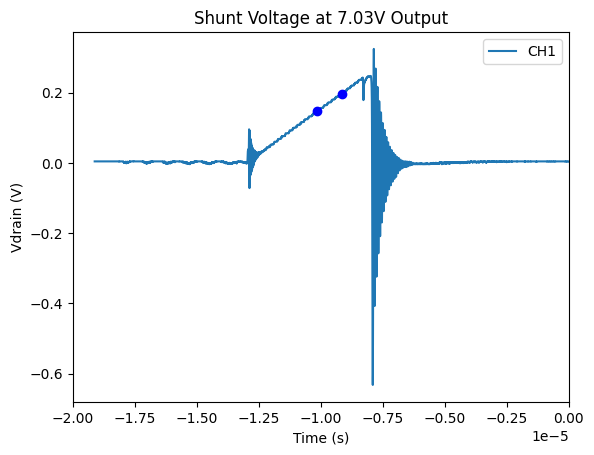

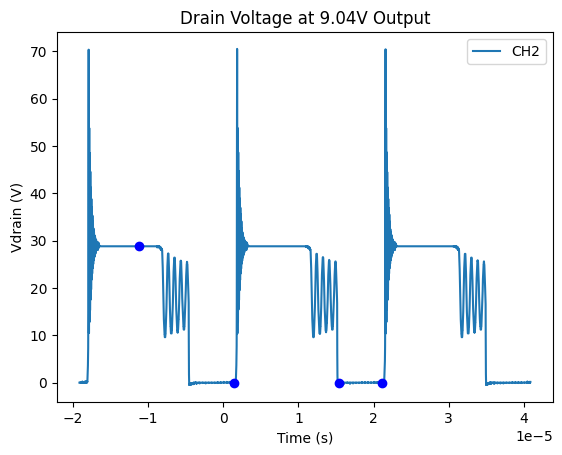

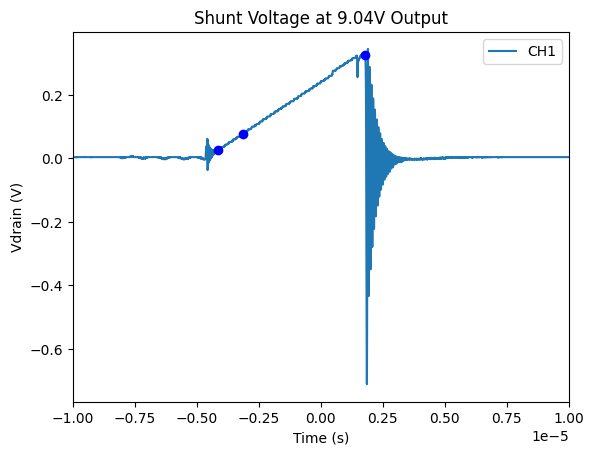

In [13]:
# Data Plotting
# Vin = 18.00V
# 4V = 4.02V, 0.28A
# 7V = 7.02V, 0.71A
# 9V = 9.04V, 1.14A
Vin = 18 #V
Vout_4V = 4.02 #V
Vout_7V = 7.03 #V
Vout_9V = 9.00 #V

# 4V
[inductor_data_4V, inductor_data_4V_t0, inductor_data_4V_dT] = read_rigol_csv('data/4V.csv')

#apply data filter
inductor_data_4V['CH1'] = inductor_data_4V['CH1'].rolling(10).mean()
inductor_data_4V['CH2'] = inductor_data_4V['CH2'].rolling(10).mean()

inductor_data_4V['CH2'] = [x-17 for x in inductor_data_4V['CH2']]

#plot drain voltage
fig, ax = plt.subplots()
inductor_data_4V.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Drain Voltage at 4.02V Output")
ax.plot(inductor_data_4V['X'].get(8500), inductor_data_4V['CH2'].get(8500), "bo")

# Calculate turns ratio of test transformer
Vpk_4V = inductor_data_4V['CH2'].get(8500)
a_4V = Vout_4V/(Vpk_4V-Vin)
print("Calculated turns ratio for 4.02V output:", a_4V)

#plot shunt voltage
fig, ax = plt.subplots()
inductor_data_4V.plot(x="X", y="CH1", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Shunt Voltage at 4.02V Output")
ax.set_xlim((-1e-5,0e-5))
ax.plot(inductor_data_4V['X'].get(6200), inductor_data_4V['CH1'].get(6200), "bo")
ax.plot(inductor_data_4V['X'].get(6600), inductor_data_4V['CH1'].get(6600), "bo")

# Voltage across the inductor is just Vg
# calculate magentizing inductance of test transformer
Rshunt = 0.05 #Ohms
dVdt_4V = (inductor_data_4V['CH1'].get(6600)-inductor_data_4V['CH1'].get(6200))/(inductor_data_4V['X'].get(6600)-inductor_data_4V['X'].get(6200))
dIdt_4V = dVdt_4V/Rshunt
Vl_4V = Vin
L4V = Vl_4V/dIdt_4V
print("Calculated inductance for 4.02V output:", L4V)

# 7V
[inductor_data_7V, inductor_data_7V_t0, inductor_data_7V_dT] = read_rigol_csv('data/7V.csv')

#apply data filter
inductor_data_7V['CH1'] = inductor_data_7V['CH1'].rolling(10).mean()
inductor_data_7V['CH2'] = inductor_data_7V['CH2'].rolling(10).mean()

#plot drain voltage
fig, ax = plt.subplots()
inductor_data_7V.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Drain Voltage at 7.03V Output")
ax.plot(inductor_data_7V['X'].get(8000), inductor_data_7V['CH2'].get(8000), "bo")

# calculate turns ratio of test transformer
Vpk_7V = inductor_data_7V['CH2'].get(8000)
a_7V = Vout_7V/(Vpk_7V-Vin)
print("Calculated turns ratio for 7.02V output:", a_7V)

#plot shunt voltage
fig, ax = plt.subplots()
inductor_data_7V.plot(x="X", y="CH1", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Shunt Voltage at 7.03V Output")
ax.set_xlim((-2e-5,0e-5))
ax.plot(inductor_data_7V['X'].get(5000), inductor_data_7V['CH1'].get(5000), "bo")
ax.plot(inductor_data_7V['X'].get(4500), inductor_data_7V['CH1'].get(4500), "bo")

# Voltage across the inductor is just Vg
# calculate magentizing inductance of test transformer
dVdt_7V = (inductor_data_7V['CH1'].get(5000)-inductor_data_7V['CH1'].get(4500))/(inductor_data_7V['X'].get(5000)-inductor_data_7V['X'].get(4500))
dIdt_7V = dVdt_7V/Rshunt
Vl_7V = Vin
L7V = Vl_7V/dIdt_7V
print("Calculated inductance for 7.03V output:", L7V)

# 9V
[inductor_data_9V, inductor_data_9V_t0, inductor_data_9V_dT] = read_rigol_csv('data/9V.csv')

#apply data filter
inductor_data_9V['CH1'] = inductor_data_9V['CH1'].rolling(10).mean()
inductor_data_9V['CH2'] = inductor_data_9V['CH2'].rolling(10).mean()

#plot drain voltage
fig, ax = plt.subplots()
inductor_data_9V.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Drain Voltage at 9.04V Output")
ax.plot(inductor_data_9V['X'].get(4000), inductor_data_9V['CH2'].get(4000), "bo")

# duty cycle points
ax.plot(inductor_data_9V['X'].get(10300), inductor_data_9V['CH2'].get(10300), "bo")
ax.plot(inductor_data_9V['X'].get(17300), inductor_data_9V['CH2'].get(17300), "bo")
ax.plot(inductor_data_9V['X'].get(20150), inductor_data_9V['CH2'].get(20150), "bo")

# calculate turns ratio of test transformer
Vpk_9V = inductor_data_9V['CH2'].get(4000)
a_9V = Vout_9V/(Vpk_9V-Vin)
print("Calculated turns ratio for 9.04V output:", a_9V)


#plot shunt voltage
fig, ax = plt.subplots()
inductor_data_9V.plot(x="X", y="CH1", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Shunt Voltage at 9.04V Output")
ax.set_xlim((-1e-5,1e-5))
ax.plot(inductor_data_9V['X'].get(7500), inductor_data_9V['CH1'].get(7500), "bo")
ax.plot(inductor_data_9V['X'].get(8000), inductor_data_9V['CH1'].get(8000), "bo")
ax.plot(inductor_data_9V['X'].get(10450), inductor_data_9V['CH1'].get(10450), "bo")
print("Peak shunt voltage at 9.04V output:",inductor_data_9V['CH1'].get(10450))


# Voltage across the inductor is just Vg
# calculate magentizing inductance of test transformer
dVdt_9V = (inductor_data_9V['CH1'].get(8000)-inductor_data_9V['CH1'].get(7500))/(inductor_data_9V['X'].get(8000)-inductor_data_9V['X'].get(7500))
dIdt_9V = dVdt_9V/Rshunt
Vl_9V = Vin
L9V = Vl_9V/dIdt_9V
print("Calculated inductance for 9.04V output:", L9V)

# Calculate average inductance
L_avg = (L4V+L7V+L9V)/3
print("Averaged calculated inductance:",L_avg)

# Calculate average turns ratio
a_avg = (a_4V+a_7V+a_9V)/3
print("Averaged turns ratio:",a_avg)

The high and low frequency rings are plotted below, and their damped natural frequencies and damping ratios are calculated using the equations provided in 9a.

High frequency ring damped natural frequency: 14705882.35294117
High frequency ring damping ratio: 0.041188318651676034
Low frequency ring damped natural frequency: 1190476.1904761898
Low frequency ring damping ratio: 0.0577954954753709


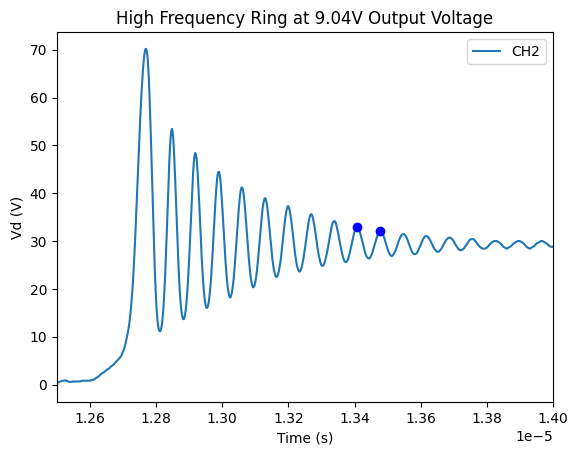

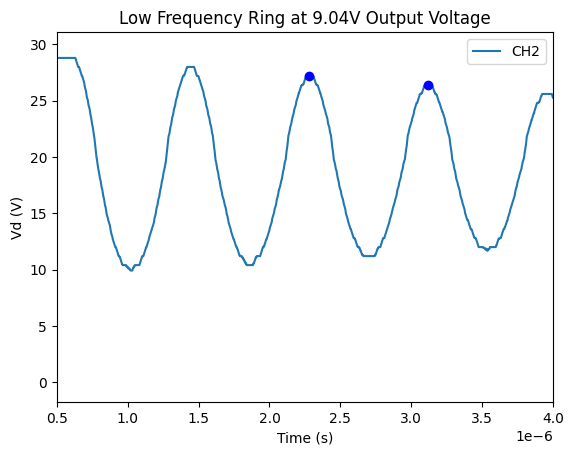

In [6]:
# Task 2 plotting
[high_9V, high_9V_t0, high_9V_dT] = read_rigol_csv('data/high_freq_osc_9V.csv')

#apply data filter
high_9V['CH1'] = high_9V['CH1'].rolling(10).mean()
high_9V['CH2'] = high_9V['CH2'].rolling(10).mean()

# plot data
#plot high freq ring, at FET turn off
fig, ax = plt.subplots()
high_9V.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vd (V)")
ax.set_title("High Frequency Ring at 9.04V Output Voltage")
ax.set_xlim(1.25e-5,1.4e-5)
ax.plot(high_9V['X'].get(4248), high_9V['CH2'].get(4248), "bo")
ax.plot(high_9V['X'].get(4214), high_9V['CH2'].get(4214), "bo")
#ax.plot(high_9V['X'].get(4179), high_9V['CH2'].get(4179), "bo")

# calculate damped natural frequency
high_damp_freq = 1/(high_9V['X'].get(4248)-high_9V['X'].get(4214))
print("High frequency ring damped natural frequency:", high_damp_freq)

# calculate damping ratio
Vpk = Vg+Vout_9V/a_avg
phi_high = log((high_9V['CH2'].get(4214)-Vpk)/(high_9V['CH2'].get(4248)-Vpk))
damp_ratio_high = 1/sqrt(1+((2*pi)/phi_high)**2)
print("High frequency ring damping ratio:",damp_ratio_high)


[low_9V, low_9V_t0, low_9V_dT] = read_rigol_csv('data/low_freq_osc_9V.csv')

#apply data filter
low_9V['CH1'] = low_9V['CH1'].rolling(10).mean()
low_9V['CH2'] = low_9V['CH2'].rolling(10).mean()

#plot low freq ring, at diode turn off
fig, ax = plt.subplots()
low_9V.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vd (V)")
ax.set_title("Low Frequency Ring at 9.04V Output Voltage")
ax.set_xlim(0.5e-6,4e-6)
ax.plot(low_9V['X'].get(3330), low_9V['CH2'].get(3330), "bo")
ax.plot(low_9V['X'].get(2910), low_9V['CH2'].get(2910), "bo")

# calculate damped natural frequency
low_damp_freq = 1/(low_9V['X'].get(3330)-low_9V['X'].get(2910))
print("Low frequency ring damped natural frequency:", low_damp_freq)

# calculate damping ratio
phi_low = log((low_9V['CH2'].get(2910)-Vpk)/(low_9V['CH2'].get(3330)-Vpk))
damp_ratio_low = 1/sqrt(1+((2*pi)/phi_low)**2)
print("Low frequency ring damping ratio:",damp_ratio_low)


## Post-Lab Analysis

6. Based on the above data, I calculated a magnetizing inductance of 18.00uH for our transformer, which is in spec (using the inductor current equation V=L*(di/dt)).

Using the equation a=Vo/(Vpk-Vg) (derived in the previous lab), I calculated the turns ratio of our transformer. Using all outputs, I calculated a turns ratio of 0.816.

9. The damped natural frequency and damping ratios of both rings are calculated above and summarized below:

High frequency ring:
- Damped natural frequency: 14.71MHz
- Damping ratio: 0.041

Low frequency ring:
- Damped natural frequency: 1.19MHz
- Damping ratio: 0.058

Both rings have very low damping ratios. This makes sense, as our converter currently has no circuitry to reduce the ringing in our circuit (either a snubber or RCD clamp).

10. We can calculate the switching frequency and duty cycle of our transformer based on the drain voltage waveforms above. Because we did not record data at 10V (instead at 9V), we will expect to see a duty cycle smaller than 0.35. Calculating these numbers below, we see a calculated duty cycle of 0.289 and a switching frequency of 50.76kHz. This duty cycle matches with my expectations, slightly below the minimum duty cycle of 0.3 due to the lower output voltage.

11. Calculating the inductance and turns ratio of our transformer based on our shunt and drain waveforms results in values that are within the transformer specifications and match our prelab calculations, at 18.01uH and 0.816 respectively. We can also calculate the alpha value of the transformer in the code block below. This results in an alpha value of 0.647, which is slightly below the 0.7 spec. This is likely due to the fact that the calculated inductance of our transformer is slightly lower than what we calculated in the prelab.

In [7]:
# calculate switching frequency
switch_freq = 1/(inductor_data_9V['X'].get(20150)-inductor_data_9V['X'].get(10300))
print("calculated switching frequency:", switch_freq)

# calculate duty cycle
switch_period = 1/switch_freq
duty_cycle = (inductor_data_9V['X'].get(17300)-inductor_data_9V['X'].get(10300))/switch_period
print("calculated duty cycle at 9V:",1-duty_cycle)

# calculate alpha value
# convert to buck-boost values
R = Ro/(a_avg**2)
Ts = 1/fs
V = 10/a
M = V/Vg

Lcrit = ((1/(M+1))**2)*R*(Ts/2)
alpha = L_avg/Lcrit
print("calculated alpha value:",alpha)

calculated switching frequency: 50761.42131979695
calculated duty cycle at 9V: 0.28934010152284273
calculated alpha value: 0.6479238247168644


## Transformer Drawing

![transformer_drawing](images/transformer_drawing.jpg)